# ODE Model

Before talking about the model, with noticed that the difference of cell cycle between proliferative 
and differentiative division is about 5 hours, so difference in proportion cannot explain by itself
the variation from 40 to 60 of Tc along corticogenesis.

Here we use ODE to test how much difference in prolif / diff division Tc can modify kinetic of the model.  
We then try to make a simple rule to control proportion of prolif / diff along time (trying to emerge 
the property, not to force it)  
We then try to see if the use of a quiescent fraction can be useful to explain the model  
We then try to use it for primate data  
We finally test robustness of this different models using euler method with noise.

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from numpy.random import choice
from scipy.interpolate import splev, splrep, interp1d
from functools import partial
from scipy.integrate import odeint
# os.chdir('/home/nathan/Desktop/ode_model/')

In [2]:
# creating function for Q fraction
timestep =   [11, 12, 13, 14, 15, 16, 17]
q_fraction = [0, 0.11, 0.19, 0.36, 0.67, 0.79, 1]
_q_func = interp1d(timestep, q_fraction)
Tc_func = interp1d([11, 17], [8, 18])
_k_tc = lambda t: np.log(2) / Tc_func(t) * 24  # to convert hours into days

clip = lambda a, b, c: np.minimum(np.maximum(a, b), c)

q_func = lambda t: _q_func(clip(t, 11, 17))
k_tc = lambda t: _k_tc(clip(t, 11, 17))

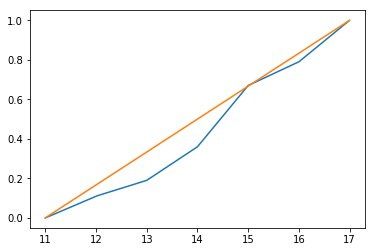

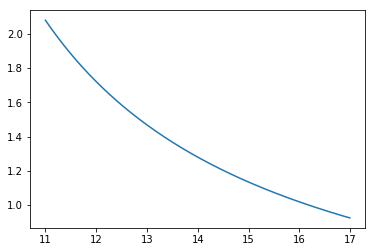

In [3]:
steps = np.arange(11, 17, 0.01)
plt.plot(steps, q_func(steps))
plt.plot([11, 17], [0, 1])
plt.show()
plt.plot(steps, k_tc(steps))

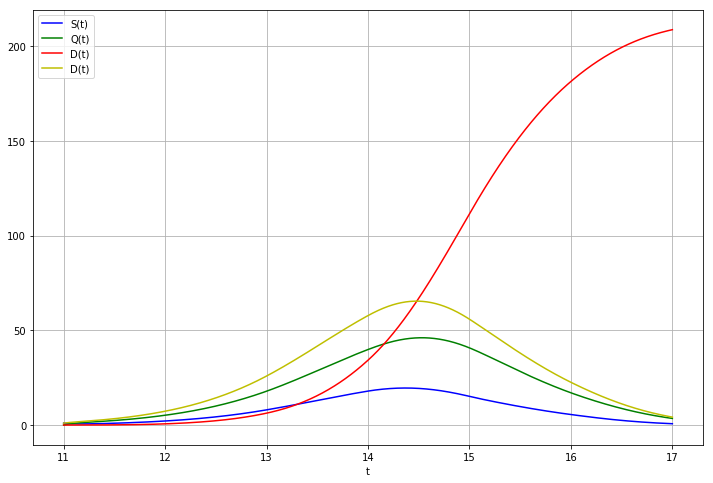

In [55]:
def pend(y, t, b=0.25, c=5.):
    theta, omega = y
    dydt = [omega, -b*omega - c*np.sin(theta)]
    return dydt

def population(y, t, q_func, k_tc, coeff = 3.4):
    S, Q, D = y
    dS = (1 - q_func(t)) * Q - k_tc(t) * S
    dQ = 2 * k_tc(t) * S - Q
    dD = q_func(t) * Q
    return np.array([dS, dQ, dD]) * coeff
    

y0 = [1, 0, 0]
t = np.linspace(11, 17, 1001)

sol = odeint(population, y0, t, args=(q_func, k_tc))

plt.figure(figsize=(12, 8))
plt.plot(t, sol[:, 0], 'b', label='S(t)')
plt.plot(t, sol[:, 1], 'g', label='Q(t)')
plt.plot(t, sol[:, 2], 'r', label='D(t)')
plt.plot(t, sol[:, 0] + sol[:, 1], 'y', label='D(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

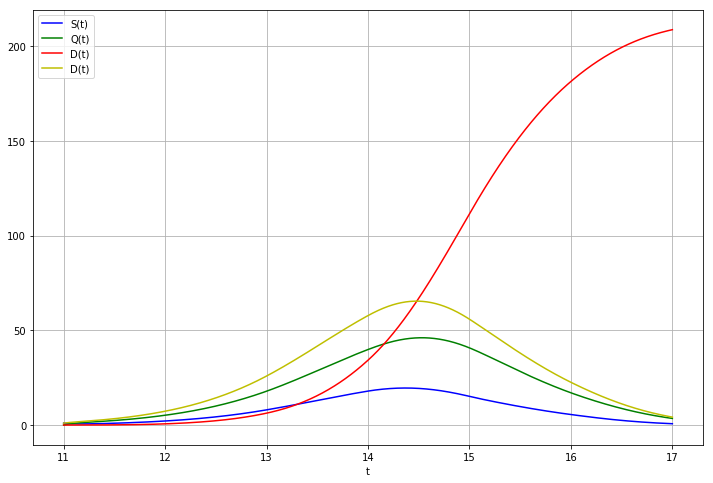

In [60]:
# here we test effect of the difference between Tc if prolif or diff

def population(y, t, q_func, k_tc, coeff = 3.4):
    S, Q, D = y
    p = q_func(t)
    k_ref = k_tc(t)
    
    k_n = k_ref / (0.9 + p / 10)  # so as effective k stay the same even though p changes
    k_p = 0.9 * k_n
    
    dS = (1 - p) * Q - k_ref * S
    dQ = 2 * k_p * (1 - p) * S + 2 * k_n * (p) * S - Q
    dD = p * Q
    return np.array([dS, dQ, dD]) * coeff
    

y0 = [1, 0, 0]
t = np.linspace(11, 17, 1001)

sol = odeint(population, y0, t, args=(q_func, k_tc))

plt.figure(figsize=(12, 8))
plt.plot(t, sol[:, 0], 'b', label='S(t)')
plt.plot(t, sol[:, 1], 'g', label='Q(t)')
plt.plot(t, sol[:, 2], 'r', label='D(t)')
plt.plot(t, sol[:, 0] + sol[:, 1], 'y', label='D(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

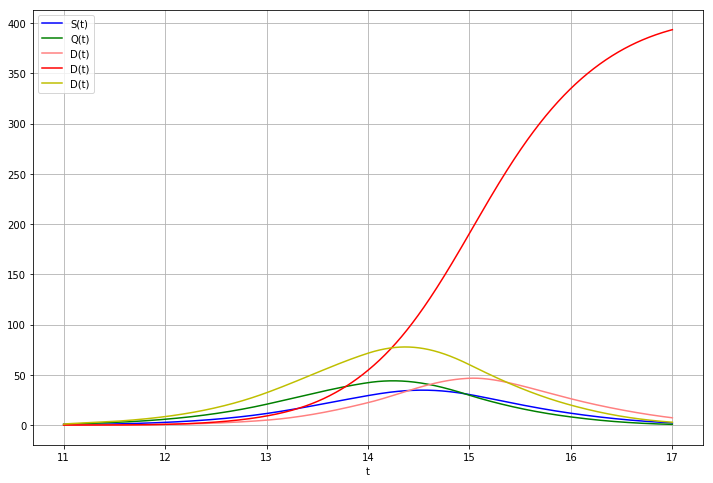

In [70]:
# here we test effect of the difference between Tc if prolif or diff

def population_bis(y, t, q_func, k_tc, coeff = 3.75):
    S, Q_p, Q_n, D = y
    p = q_func(t)
    k_ref = k_tc(t)
    
    k_n = k_ref / (0.9 + p / 10)  # so as effective k stay the same even though p changes
    k_p = 0.9 * k_n
    
    dS = Q_p - k_ref * S
    dQ_p = 2 * k_p * (1 - p) * S - Q_p
    dQ_n = 2 * k_n * (p) * S - Q_n
    dD = Q_n
    return np.array([dS, dQ_p, dQ_n, dD]) * coeff
    

y0 = [1, 0, 0, 0]
t = np.linspace(11, 17, 1001)

sol = odeint(population_bis, y0, t, args=(q_func, k_tc))

plt.figure(figsize=(12, 8))
plt.plot(t, sol[:, 0], 'b', label='S(t)')
plt.plot(t, sol[:, 1], 'g', label='Q(t)')
plt.plot(t, sol[:, 2], color=(1, 0.5, 0.5), label='D(t)')
plt.plot(t, sol[:, 3], 'r', label='D(t)')
plt.plot(t, sol[:, 0] + sol[:, 1], 'y', label='D(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

We can see a difference of a factor 2, this remains to be confirmed by agent-based model  

Now we check if by using only D / all ratio we can simulate quite the same shape of curve

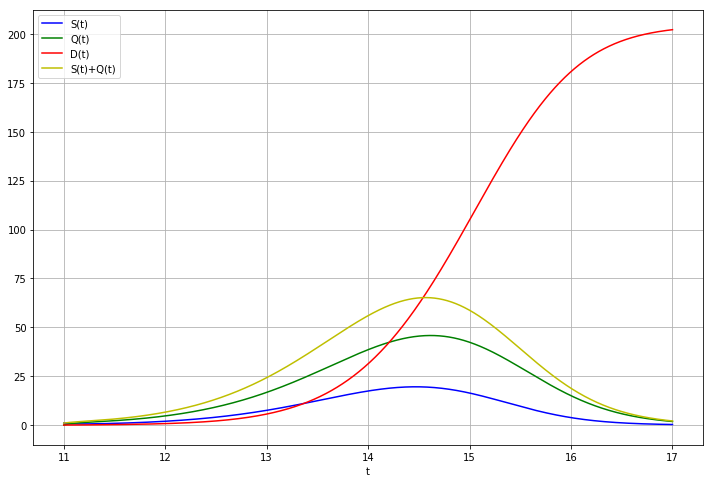

In [79]:
def population(y, t, q_func, k_tc, coeff = 3.4, eps=0.09):
    S, Q, D = y
    p = q_func(t)
    p = max(D / (D + Q + S), eps)
    k_ref = k_tc(t)
    dS = (1 - p) * Q - k_tc(t) * S
    dQ = 2 * k_ref * S - Q
    dD = p * Q
    return np.array([dS, dQ, dD]) * coeff
    

y0 = [1, 0, 0]
t = np.linspace(11, 17, 1001)

sol = odeint(population, y0, t, args=(q_func, k_tc))

plt.figure(figsize=(12, 8))
plt.plot(t, sol[:, 0], 'b', label='S(t)')
plt.plot(t, sol[:, 1], 'g', label='Q(t)')
plt.plot(t, sol[:, 2], 'r', label='D(t)')
plt.plot(t, sol[:, 0] + sol[:, 1], 'y', label='S(t)+Q(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

It can work with only an inner mechanism for q leaving fraction function, but obviously there are mistakes in this model.  
First, not all progenitors are consumed at the end (for gliogenesis), then number of progenitor along time does not refer to anything.  
We now focus on primate data.

In [84]:
clip = lambda a, b, c: np.minimum(np.maximum(a, b), c)

# from PolynomRegression
Tc_func_primate = lambda time: 277.36424309532794 - 0.023973977538587 * time - 0.761568634472077 * time**2 + \
    0.025594287611410 * time**3 - 0.000307496975562 * time**4 + 0.000001264230759 * time**5

timesteps = np.array([49, 61, 72, 83, 95])
diff_values = 1 - np.array([0.75, 0.64, 0.38, 0.60, 0.30])
_q_func_primate = interp1d(timesteps, diff_values)
_k_tc_primate = lambda t: np.log(2) / Tc_func_primate(t) * 24  # to convert hours into days

q_func_primate = lambda t: _q_func_primate(clip(t, 49, 95))
k_tc_primate = lambda t: _k_tc_primate(clip(t, 49, 95))

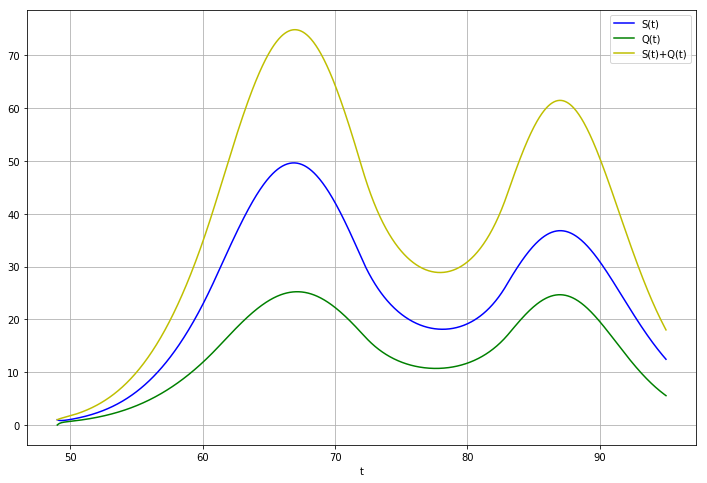

In [86]:
def population(y, t, q_func, k_tc, coeff = 3.4, eps=0.09):
    S, Q, D = y
    p = q_func(t)
    # p = max(D / (D + Q + S), eps)
    k_ref = k_tc(t)
    dS = (1 - p) * Q - k_tc(t) * S
    dQ = 2 * k_ref * S - Q
    dD = p * Q
    return np.array([dS, dQ, dD]) * coeff
    

y0 = [1, 0, 0]
t = np.linspace(49, 95, 1001)

sol = odeint(population, y0, t, args=(q_func_primate, k_tc_primate))

plt.figure(figsize=(12, 8))
plt.plot(t, sol[:, 0], 'b', label='S(t)')
plt.plot(t, sol[:, 1], 'g', label='Q(t)')
# plt.plot(t, sol[:, 2], 'r', label='D(t)')
plt.plot(t, sol[:, 0] + sol[:, 1], 'y', label='S(t)+Q(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

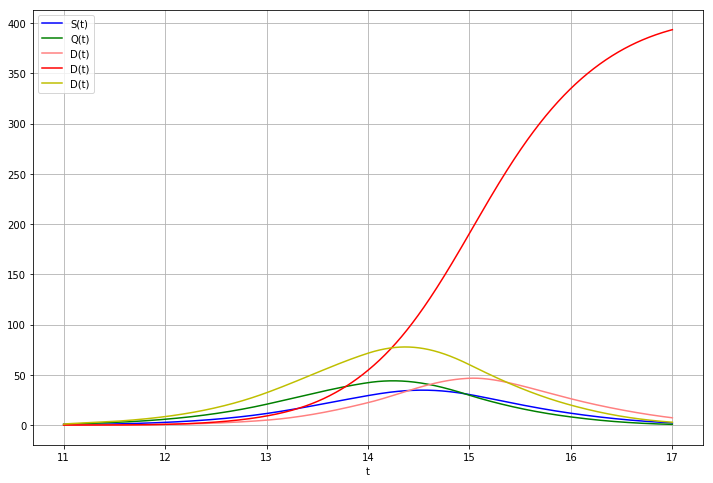

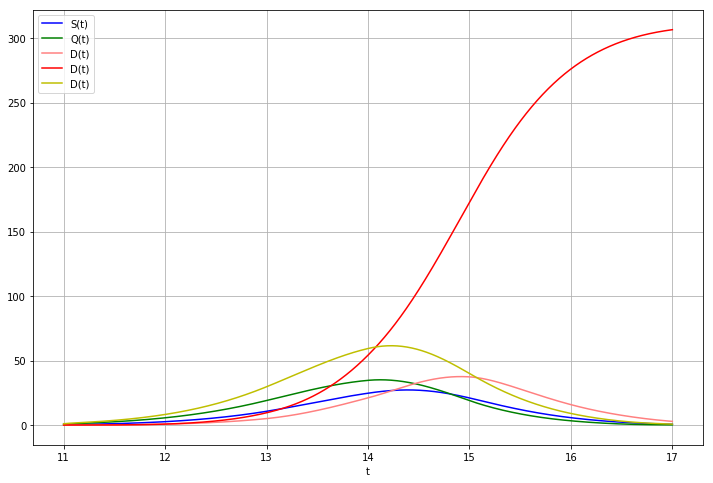

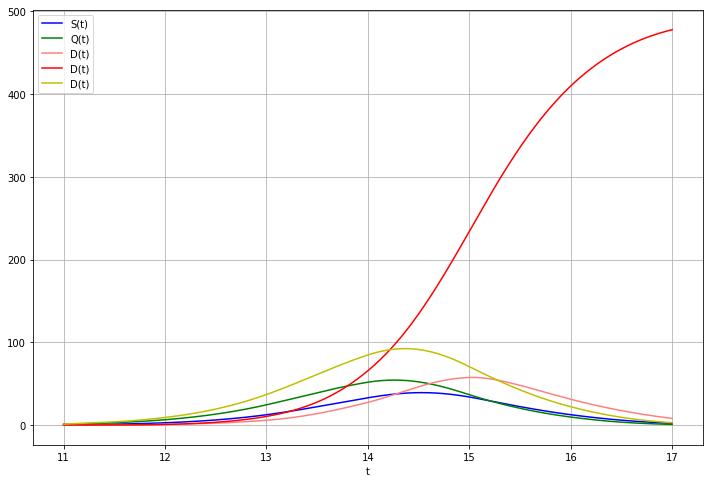

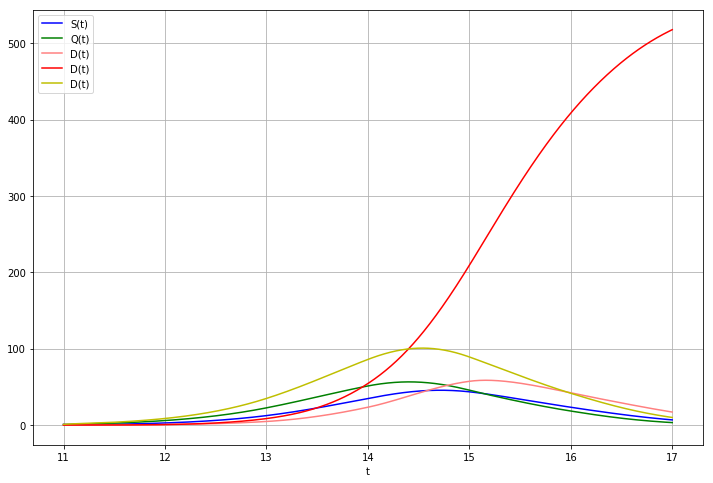

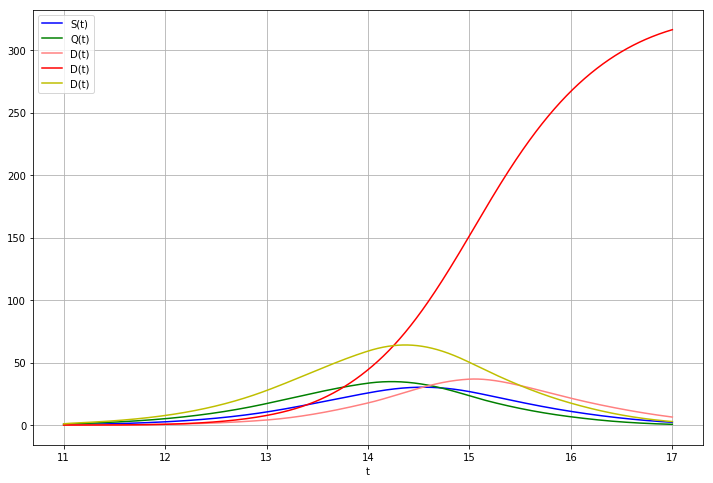

In [95]:
# here we test effect of the difference between Tc if prolif or diff

def population_bis(y, t, q_func, k_tc, pert_q=1., pert_tc=1., coeff = 3.75):
    S, Q_p, Q_n, D = y
    p = np.clip(q_func(t) * pert_q, 0, 1)
    k_ref = k_tc(t) * pert_tc
    
    k_n = k_ref / (0.9 + p / 10)  # so as effective k stay the same even though p changes
    k_p = 0.9 * k_n
    
    dS = Q_p - k_ref * S
    dQ_p = 2 * k_p * (1 - p) * S - Q_p
    dQ_n = 2 * k_n * (p) * S - Q_n
    dD = Q_n
    return np.array([dS, dQ_p, dQ_n, dD]) * coeff
    

y0 = [1, 0, 0, 0]
t = np.linspace(11, 17, 1001)

sol = odeint(population_bis, y0, t, args=(q_func, k_tc))
sol1 = odeint(population_bis, y0, t, args=(q_func, k_tc, 1.1, 1.))
sol2 = odeint(population_bis, y0, t, args=(q_func, k_tc, 1., 1.1))
sol3 = odeint(population_bis, y0, t, args=(q_func, k_tc, 0.9, 1.))
sol4 = odeint(population_bis, y0, t, args=(q_func, k_tc, 1., 0.9))
def show_solution(sol):
    plt.figure(figsize=(12, 8))
    plt.plot(t, sol[:, 0], 'b', label='S(t)')
    plt.plot(t, sol[:, 1], 'g', label='Q(t)')
    plt.plot(t, sol[:, 2], color=(1, 0.5, 0.5), label='D(t)')
    plt.plot(t, sol[:, 3], 'r', label='D(t)')
    plt.plot(t, sol[:, 0] + sol[:, 1], 'y', label='D(t)')
    plt.legend(loc='best')
    plt.xlabel('t')
    plt.grid()
    plt.show()
show_solution(sol)
show_solution(sol1)
show_solution(sol2)
show_solution(sol3)
show_solution(sol4)

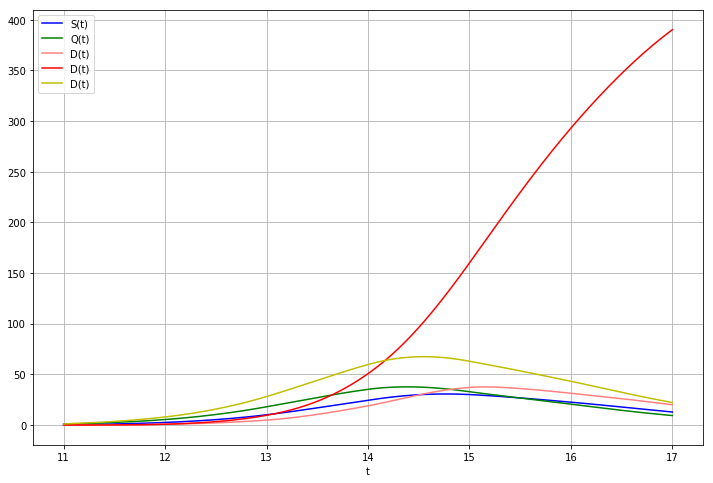

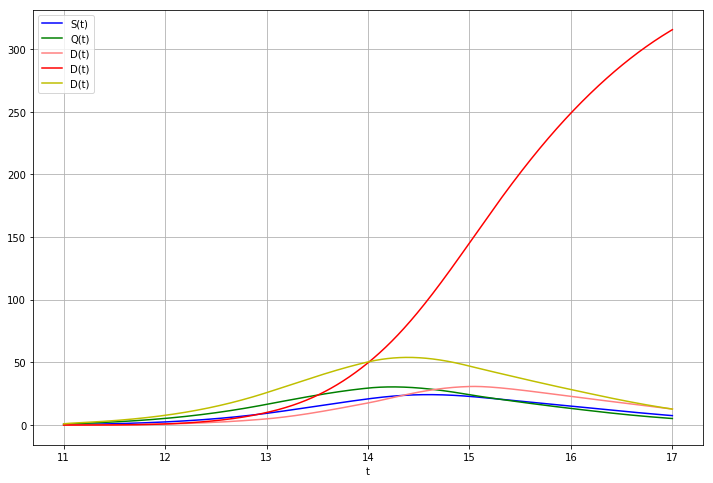

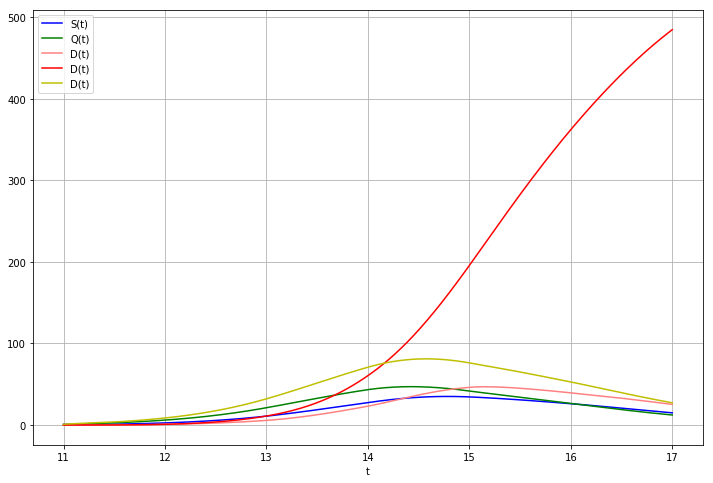

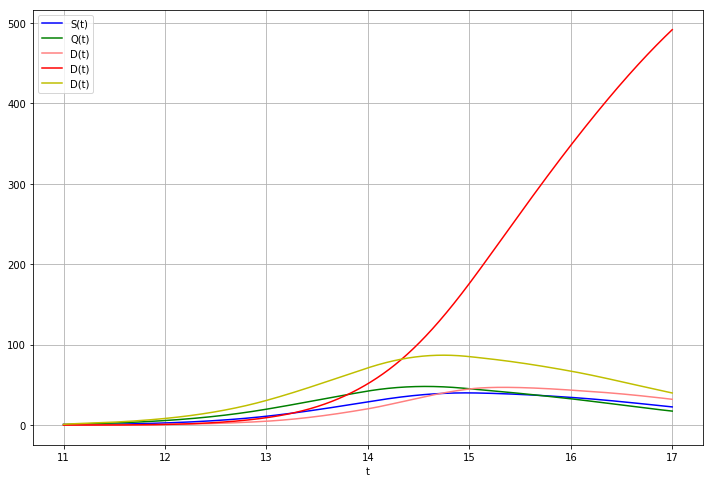

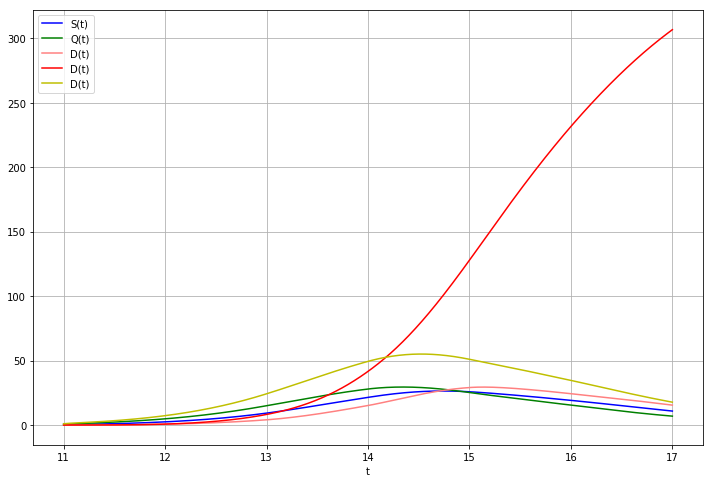

In [102]:
# here we test effect of the difference between Tc if prolif or diff

def population_bis(y, t, q_func, k_tc, pert_q=1., pert_tc=1., coeff = 3.75, coeff_inh=1.):
    S, Q_p, Q_n, D = y
    inh = (Q_n / (Q_n + Q_p + S)) * coeff_inh  # inhibition term
    p = q_func(t) * (1 - inh) * 1.3 * pert_q
    p = np.clip(p, 0, 1)
    k_ref = k_tc(t) * pert_tc
    
    k_n = k_ref / (0.9 + p / 10)  # so as effective k stay the same even though p changes
    k_p = 0.9 * k_n
    
    dS = Q_p - k_ref * S
    dQ_p = 2 * k_p * (1 - p) * S - Q_p
    dQ_n = 2 * k_n * (p) * S - Q_n
    dD = Q_n
    return np.array([dS, dQ_p, dQ_n, dD]) * coeff
    

y0 = [1, 0, 0, 0]
t = np.linspace(11, 17, 1001)

sol = odeint(population_bis, y0, t, args=(q_func, k_tc))
sol1 = odeint(population_bis, y0, t, args=(q_func, k_tc, 1.1, 1.))
sol2 = odeint(population_bis, y0, t, args=(q_func, k_tc, 1., 1.1))
sol3 = odeint(population_bis, y0, t, args=(q_func, k_tc, 0.9, 1.))
sol4 = odeint(population_bis, y0, t, args=(q_func, k_tc, 1., 0.9))
def show_solution(sol):
    plt.figure(figsize=(12, 8))
    plt.plot(t, sol[:, 0], 'b', label='S(t)')
    plt.plot(t, sol[:, 1], 'g', label='Q(t)')
    plt.plot(t, sol[:, 2], color=(1, 0.5, 0.5), label='D(t)')
    plt.plot(t, sol[:, 3], 'r', label='D(t)')
    plt.plot(t, sol[:, 0] + sol[:, 1], 'y', label='D(t)')
    plt.legend(loc='best')
    plt.xlabel('t')
    plt.grid()
    plt.show()
show_solution(sol)
show_solution(sol1)
show_solution(sol2)
show_solution(sol3)
show_solution(sol4)

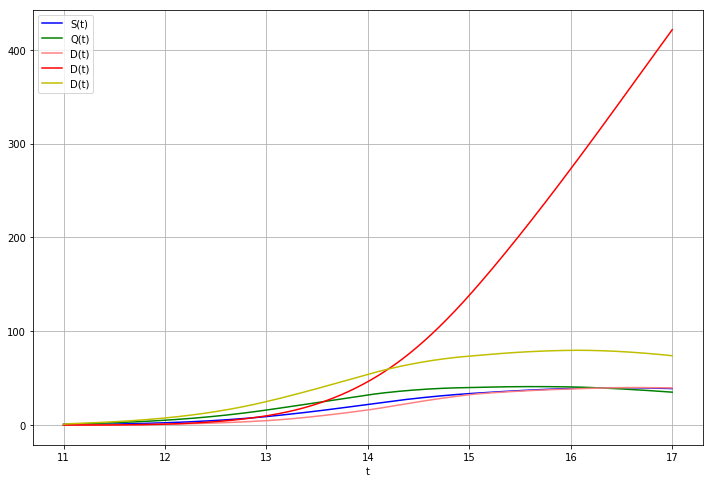

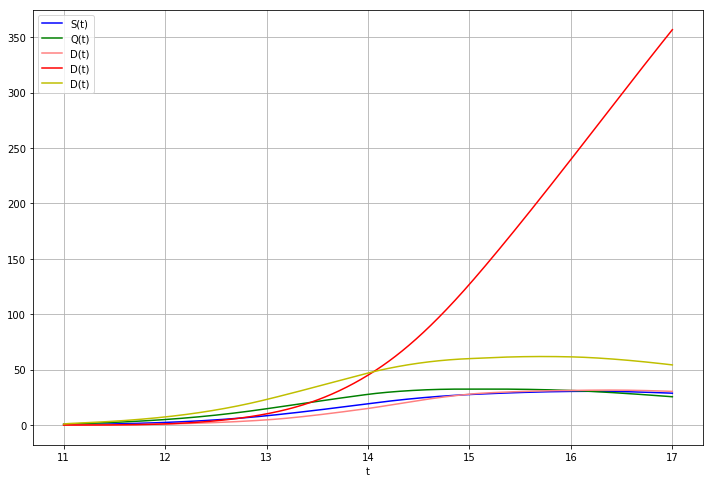

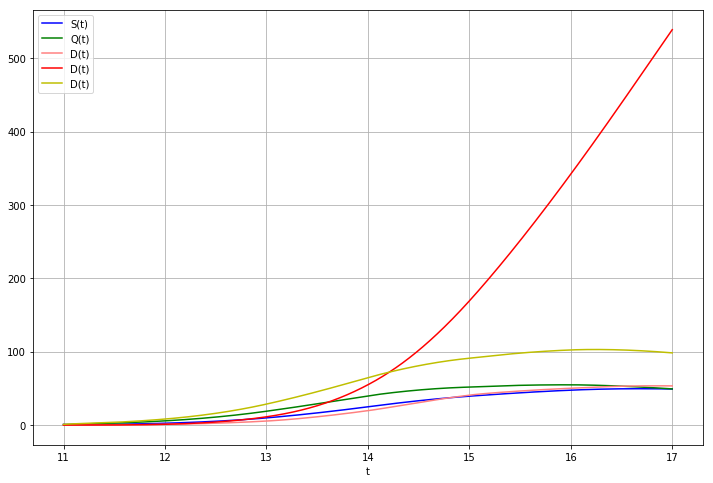

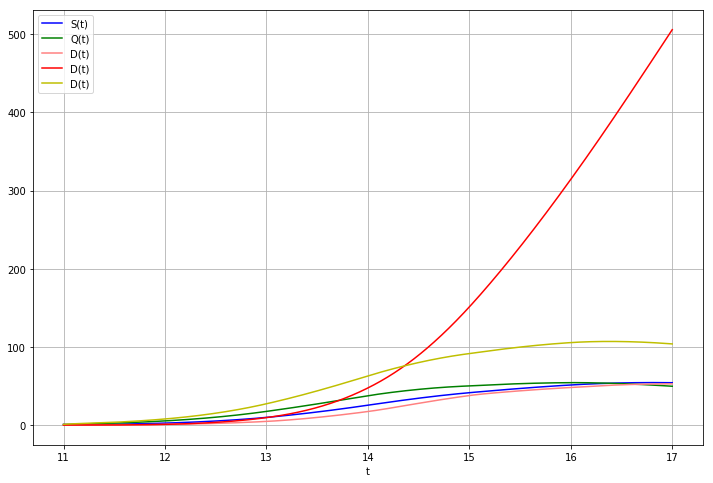

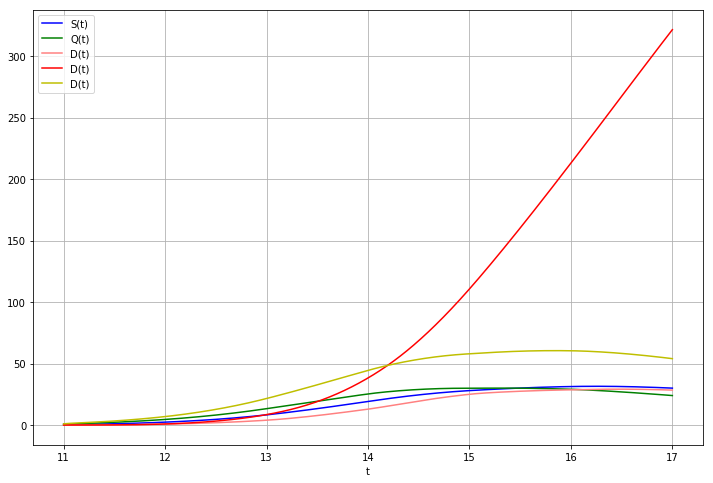

In [107]:
# here we test effect of the difference between Tc if prolif or diff

def population_bis(y, t, q_func, k_tc, pert_q=1., pert_tc=1., coeff = 3.75, coeff_inh=2.):
    S, Q_p, Q_n, D = y
    inh = (Q_n / (Q_n + Q_p + S)) * coeff_inh  # inhibition term
    p = q_func(t) * (1 - inh) * 1.7 * pert_q
    p = np.clip(p, 0, 1)
    k_ref = k_tc(t) * pert_tc
    
    k_n = k_ref / (0.9 + p / 10)  # so as effective k stay the same even though p changes
    k_p = 0.9 * k_n
    
    dS = Q_p - k_ref * S
    dQ_p = 2 * k_p * (1 - p) * S - Q_p
    dQ_n = 2 * k_n * (p) * S - Q_n
    dD = Q_n
    return np.array([dS, dQ_p, dQ_n, dD]) * coeff
    

y0 = [1, 0, 0, 0]
t = np.linspace(11, 17, 1001)

sol = odeint(population_bis, y0, t, args=(q_func, k_tc))
sol1 = odeint(population_bis, y0, t, args=(q_func, k_tc, 1.1, 1.))
sol2 = odeint(population_bis, y0, t, args=(q_func, k_tc, 1., 1.1))
sol3 = odeint(population_bis, y0, t, args=(q_func, k_tc, 0.9, 1.))
sol4 = odeint(population_bis, y0, t, args=(q_func, k_tc, 1., 0.9))
def show_solution(sol):
    plt.figure(figsize=(12, 8))
    plt.plot(t, sol[:, 0], 'b', label='S(t)')
    plt.plot(t, sol[:, 1], 'g', label='Q(t)')
    plt.plot(t, sol[:, 2], color=(1, 0.5, 0.5), label='D(t)')
    plt.plot(t, sol[:, 3], 'r', label='D(t)')
    plt.plot(t, sol[:, 0] + sol[:, 1], 'y', label='D(t)')
    plt.legend(loc='best')
    plt.xlabel('t')
    plt.grid()
    plt.show()
show_solution(sol)
show_solution(sol1)
show_solution(sol2)
show_solution(sol3)
show_solution(sol4)

Not really working, variation as the same magnitude of order

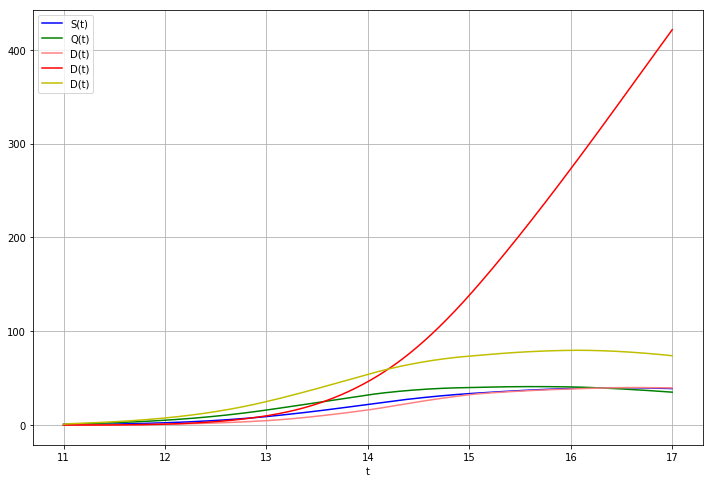

In [115]:
# here we test effect of the difference between Tc if prolif or diff

def population_bis(y, t, q_func, k_tc, pert_q=1., pert_tc=1., coeff = 3.75, coeff_inh=2.):
    S, Q_p, Q_n, D, p = y
    inh = (Q_n / (Q_n + Q_p + S)) * coeff_inh  # inhibition term
    # p = q_func(t) * (1 - inh) * 1.7 * pert_q
    p = q_func(t) * (1 - inh) * 1.7 * pert_q
    p = np.clip(p, 0, 1)
    k_ref = k_tc(t) * pert_tc
    
    k_n = k_ref / (0.9 + p / 10)  # so as effective k stay the same even though p changes
    k_p = 0.9 * k_n
    
    dS = Q_p - k_ref * S
    dQ_p = 2 * k_p * (1 - p) * S - Q_p
    dQ_n = 2 * k_n * (p) * S - Q_n
    dD = Q_n
    dp = S * 0.005
    return np.array([dS, dQ_p, dQ_n, dD, dp]) * coeff
    

y0 = [1, 0, 0, 0, 0]
t = np.linspace(11, 17, 1001)

sol = odeint(population_bis, y0, t, args=(q_func, k_tc))
def show_solution(sol):
    plt.figure(figsize=(12, 8))
    plt.plot(t, sol[:, 0], 'b', label='S(t)')
    plt.plot(t, sol[:, 1], 'g', label='Q(t)')
    plt.plot(t, sol[:, 2], color=(1, 0.5, 0.5), label='D(t)')
    plt.plot(t, sol[:, 3], 'r', label='D(t)')
    plt.plot(t, sol[:, 0] + sol[:, 1], 'y', label='D(t)')
    plt.legend(loc='best')
    plt.xlabel('t')
    plt.grid()
    plt.show()
show_solution(sol)


Model can work with p being an integration of S over time. However integration of a number of cell is highly unlikely  
We decide to use 2 compartments for progenitors, namely bRG and IP to see if this can make emerge the p growth over time.

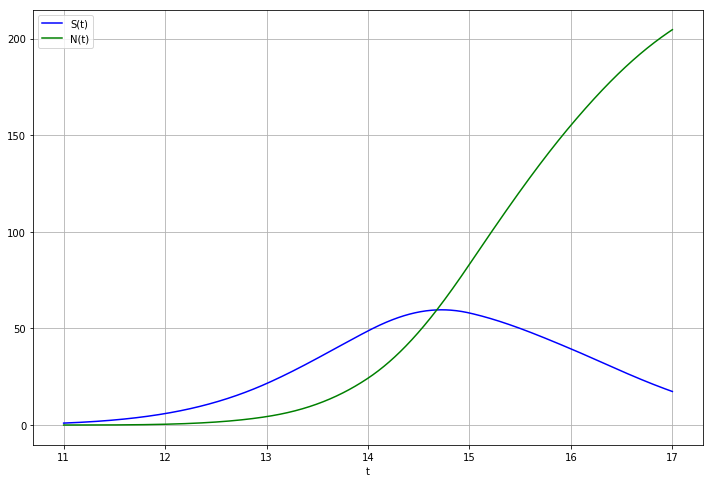

In [126]:
# here we test if one compartment can work (no cycle)
def population_bis(y, t, q_func, k_tc, pert_q=1., pert_tc=1., coeff = 1, coeff_inh=2.):
    S, N = y
    
    p = q_func(t) * pert_q
    p = np.clip(p, 0, 1)
    k_ref = k_tc(t) * pert_tc
    
    dS = (k_ref - 2 * p) * S
    dN = 2 * p * S
    return np.array([dS, dN]) * coeff
    

y0 = [1, 0]
t = np.linspace(11, 17, 1001)

sol = odeint(population_bis, y0, t, args=(q_func, k_tc))
def show_solution(sol):
    plt.figure(figsize=(12, 8))
    plt.plot(t, sol[:, 0], 'b', label='S(t)')
    plt.plot(t, sol[:, 1], 'g', label='N(t)')
    plt.legend(loc='best')
    plt.xlabel('t')
    plt.grid()
    plt.show()
show_solution(sol)


I think we could get the very same shape but this is sufficient, so for so models we won't consider the Q population

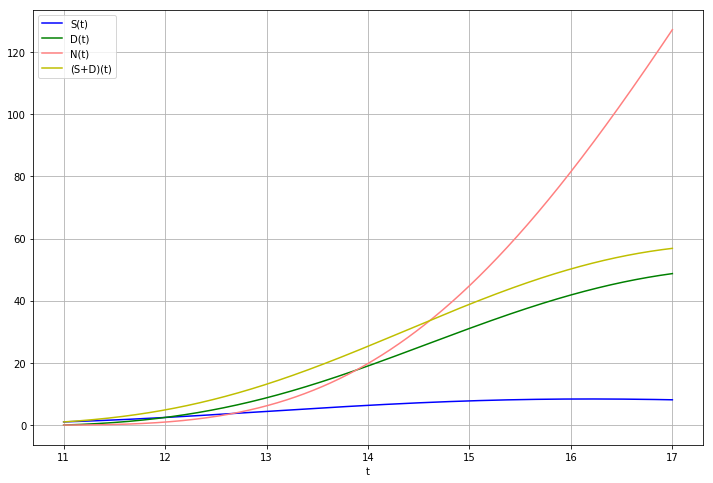

In [135]:
# here we test with two compartments of progenitors

def population_bis(y, t, q_func, k_tc, pert_q=1., pert_tc=1., coeff = 1., coeff_inh=2.):
    S, D, N = y # Q stands for quiescent
    # inh = (Q_n / (Q_n + Q_p + S)) * coeff_inh  # inhibition term
    # p = q_func(t) * (1 - inh) * 1.7 * pert_q
    p = q_func(t) * pert_q
    p = np.clip(p, 0, 1)
    p_n = 0.5
    p_p = 0.5
    k_ref = k_tc(t) * pert_tc
    
    k_n = k_ref / (0.9 + p / 10)  # so as effective k stay the same even though p changes
    k_p = 0.9 * k_n
    
    dS = (k_ref - 2 * p_p) * S
    dD = 2 * p_p * S + (k_ref - 2 * p_n) * D
    dN = 2 * p_n * D
    return np.array([dS, dD, dN]) * coeff
    

y0 = [1, 0, 0]
t = np.linspace(11, 17, 1001)

sol = odeint(population_bis, y0, t, args=(q_func, k_tc))
def show_solution(sol):
    plt.figure(figsize=(12, 8))
    plt.plot(t, sol[:, 0], 'b', label='S(t)')
    plt.plot(t, sol[:, 1], 'g', label='D(t)')
    plt.plot(t, sol[:, 2], color=(1, 0.5, 0.5), label='N(t)')
    plt.plot(t, sol[:, 0] + sol[:, 1], 'y', label='(S+D)(t)')
    plt.legend(loc='best')
    plt.xlabel('t')
    plt.grid()
    plt.show()
show_solution(sol)
# ccls : kinetic can work, but there is there nothing that stops increase of IP

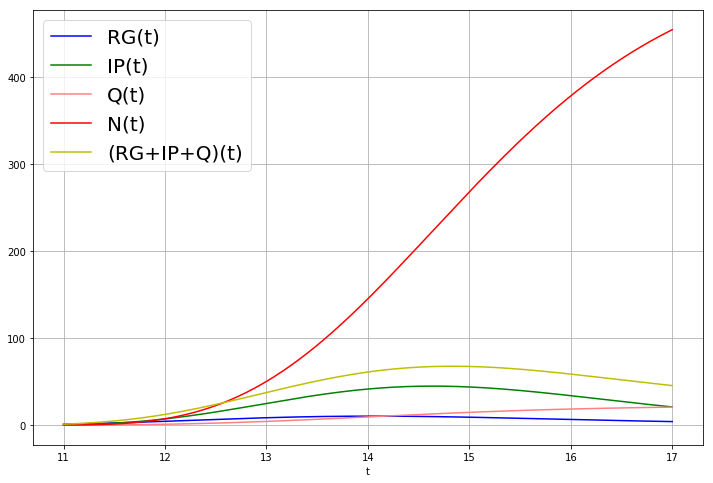

In [4]:
# here we test 

def population_bis(y, t, q_func, k_tc, pert_q=1., pert_tc=1., coeff = 2., coeff_inh=2.):
    S, D, N, Q = y # Q stands for quiescent
    # inh = (Q_n / (Q_n + Q_p + S)) * coeff_inh  # inhibition term
    # p = q_func(t) * (1 - inh) * 1.7 * pert_q
    p = q_func(t) * pert_q
    p = np.clip(p, 0, 1)
    p_n = 0.7
    p_p = 0.5
    k_ref = k_tc(t) * pert_tc
    p_q = D / (D + S + Q) * 0.4
    
    k_n = k_ref / (0.9 + p / 10)  # so as effective k stay the same even though p changes
    k_p = 0.9 * k_n
    
    dS = (k_ref - 2 * p_p - p_q) * S
    dD = 2 * p_p * S + (k_ref - 2 * p_n) * D
    dN = 2 * p_n * D
    dQ = p_q * S
    
    return np.array([dS, dD, dN, dQ]) * coeff
    

y0 = [1, 0, 0, 0]
t = np.linspace(11, 17, 1001)

sol = odeint(population_bis, y0, t, args=(q_func, k_tc))
def show_solution(sol):
    plt.figure(figsize=(12, 8))
    plt.plot(t, sol[:, 0], 'b', label='RG(t)')
    plt.plot(t, sol[:, 1], 'g', label='IP(t)')
    plt.plot(t, sol[:, 3], color=(1, 0.5, 0.5), label='Q(t)')
    plt.plot(t, sol[:, 2], 'r', label='N(t)')
    plt.plot(t, sol[:, 0] + sol[:, 1] + sol[:, 3], 'y', label='(RG+IP+Q)(t)')
    plt.legend(loc='best', fontsize=20)
    plt.xlabel('t')
    plt.grid()
    plt.show()
show_solution(sol)


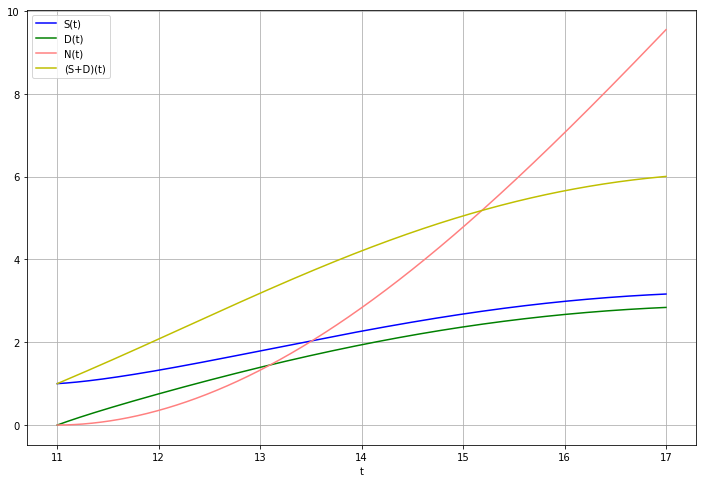

In [11]:
# same but now we have only two progenitor types

def population_bis(y, t, q_func, k_tc, pert_q=1., pert_tc=1., coeff = 0.5, coeff_inh=2.):
    S, D, N = y # Q stands for quiescent
    # inh = (Q_n / (Q_n + Q_p + S)) * coeff_inh  # inhibition term
    # p = q_func(t) * (1 - inh) * 1.7 * pert_q
    p = q_func(t) * pert_q
    p = np.clip(p, 0, 1)
    p_n = 0.9
    p_p = 0.9 - (D / (D + S))
    k_ref = k_tc(t) * pert_tc
    
    k_n = k_ref / (0.9 + p / 10)  # so as effective k stay the same even though p changes
    k_p = 0.9 * k_n
    
    dS = (k_ref - 2 * p_p) * S
    dD = 2 * p_p * S + (k_ref - 2 * p_n) * D
    dN = 2 * p_n * D
    return np.array([dS, dD, dN]) * coeff
    

y0 = [1, 0, 0]
t = np.linspace(11, 17, 1001)

sol = odeint(population_bis, y0, t, args=(q_func, k_tc))
def show_solution(sol):
    plt.figure(figsize=(12, 8))
    plt.plot(t, sol[:, 0], 'b', label='S(t)')
    plt.plot(t, sol[:, 1], 'g', label='D(t)')
    plt.plot(t, sol[:, 2], color=(1, 0.5, 0.5), label='N(t)')
    plt.plot(t, sol[:, 0] + sol[:, 1], 'y', label='(S+D)(t)')
    plt.legend(loc='best')
    plt.xlabel('t')
    plt.grid()
    plt.show()
show_solution(sol)
# ccls : kinetic can work, but there is there nothing that stops increase of IP

In [ ]:
# same but now we have only two progenitor types TBC

def population_bis(y, t, q_func, k_tc, pert_q=1., pert_tc=1., coeff = 2., coeff_inh=2.):
    S, D, N = y
    
    p = q_func(t) * pert_q
    p = np.clip(p, 0, 1)
    p_n = 0.7
    p_p = 0.5
    k_ref = k_tc(t) * pert_tc
    p_q = D / (D + S + Q) * 0.4
    
    k_n = k_ref / (0.9 + p / 10)  # so as effective k stay the same even though p changes
    k_p = 0.9 * k_n
    
    dS = (k_ref - 2 * p_p - p_q) * S
    dD = 2 * p_p * S + (k_ref - 2 * p_n) * D
    dN = 2 * p_n * D
    
    return np.array([dS, dD, dN, dQ]) * coeff
    

y0 = [1, 0, 0, 0]
t = np.linspace(11, 17, 1001)

sol = odeint(population_bis, y0, t, args=(q_func, k_tc))
def show_solution(sol):
    plt.figure(figsize=(12, 8))
    plt.plot(t, sol[:, 0], 'b', label='RG(t)')
    plt.plot(t, sol[:, 1], 'g', label='IP(t)')
    plt.plot(t, sol[:, 2], 'r', label='N(t)')
    plt.plot(t, sol[:, 0] + sol[:, 1], 'y', label='(RG+IP+Q)(t)')
    plt.legend(loc='best', fontsize=20)
    plt.xlabel('t')
    plt.grid()
    plt.show()
show_solution(sol)
